In [22]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import uniform
import os
from os import listdir, getcwd
import re
import sys
import warnings
import sklearn
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import clear_output

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, LeaveOneGroupOut, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectFpr, SelectFwe, RFECV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.linear_model import ElasticNetCV, LogisticRegression, SGDClassifier, LogisticRegressionCV, LarsCV, LassoLarsCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')
%matplotlib inline

In [23]:
X_train = np.load('../data/processed/X_train.npy')
X_test = np.load('../data/processed/X_test.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

with open('../data/processed/feature_names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines()]

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Features: {len(feature_names)}")

Train: (472, 27)
Test: (119, 27)
Features: 27


## Carregar modelos treinados anteriormente

In [24]:
import os

model_dir = '../models/'
trained_models = {}

if os.path.exists(model_dir):
    for filename in os.listdir(model_dir):
        if filename.endswith('.pkl'):
            model_name = filename.replace('.pkl', '')
            with open(os.path.join(model_dir, filename), 'rb') as f:
                trained_models[model_name] = pickle.load(f)

print(f"Modelos carregados: {len(trained_models)}")
print(list(trained_models.keys()))

Modelos carregados: 36
['ensemble_rank_averaging', 'svm_rbf_bayessearch', 'ensemble_voting_optimized', 'advanced_xgboost_top15', 'logistic_regression_optimized', 'logistic_regression_bayessearch', 'svm_rbf_optimized', 'ensemble_weighted_rank', 'advanced_xgboost_all', 'advanced_mlp_all', 'advanced_lightgbm_top15', 'bayesopt_mlp_rfe', 'bayesopt_gradient_boosting_all', 'advanced_mlp_top10', 'svm_linear_baseline', 'bayesopt_mlp_all', 'naive_bayes_baseline', 'ensemble_baseline_advanced', 'logistic_regression_baseline', 'random_forest_bayessearch', 'bayesopt_gradient_boosting_rfe', 'advanced_lightgbm_top10', 'bayesopt_lightgbm_rfe', 'advanced_lightgbm_all', 'bayesopt_elastic_net_all', 'random_forest_baseline', 'random_forest_optimized', 'bayesopt_xgboost_rfe', 'bayesopt_svm_rbf_rfe', 'advanced_mlp_top15', 'bayesopt_xgboost_all', 'bayesopt_elastic_net_rfe', 'advanced_xgboost_top10', 'bayesopt_lightgbm_all', 'naive_bayes_optimized', 'bayesopt_svm_rbf_all']


## Configuracao dos modelos base

In [25]:
base_models = {
    'elastic_net': SGDClassifier(loss='log_loss', penalty='elasticnet', l1_ratio=0.5, 
                                  alpha=0.0001, max_iter=2000, random_state=42),
    
    'svm_rbf': SVC(kernel='rbf', C=10, gamma=0.01, probability=True, random_state=42),
    
    'svm_linear': SVC(kernel='linear', C=1.0, probability=True, random_state=42),
    
    'random_forest': RandomForestClassifier(n_estimators=500, max_depth=10, 
                                            min_samples_split=10, random_state=42),
    
    'gradient_boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1,
                                                    max_depth=3, subsample=0.8, random_state=42),
    
    'xgboost': XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3,
                            subsample=0.8, colsample_bytree=0.8, random_state=42),
    
    'lightgbm': LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=3,
                               subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1),
    
    'mlp': MLPClassifier(hidden_layer_sizes=(50, 25), activation='relu',
                        alpha=0.001, learning_rate_init=0.001, max_iter=2000, random_state=42),
    
    'logistic': LogisticRegression(C=1.0, max_iter=2000, random_state=42)
}

print(f"Modelos base definidos: {len(base_models)}")

Modelos base definidos: 9


## Treinar modelos base

In [26]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

results_base = []
cv_predictions_train = {}
test_predictions = {}

for name, model in base_models.items():
    print(f"Treinando {name}...")
    
    model.fit(X_train, y_train)
    
    cv_preds = cross_val_predict(model, X_train, y_train, cv=cv_strategy, 
                                 method='predict_proba', n_jobs=-1)[:, 1]
    cv_predictions_train[name] = cv_preds
    
    cv_roc_auc = roc_auc_score(y_train, cv_preds)
    
    test_preds = model.predict_proba(X_test)[:, 1]
    test_predictions[name] = test_preds
    test_roc_auc = roc_auc_score(y_test, test_preds)
    
    results_base.append({
        'model': name,
        'cv_roc_auc': cv_roc_auc,
        'test_roc_auc': test_roc_auc
    })
    
    print(f"  CV ROC-AUC: {cv_roc_auc:.4f}")
    print(f"  Test ROC-AUC: {test_roc_auc:.4f}")

df_results_base = pd.DataFrame(results_base).sort_values('cv_roc_auc', ascending=False)
df_results_base

Treinando elastic_net...
  CV ROC-AUC: 0.8592
  Test ROC-AUC: 0.8679
Treinando svm_rbf...
  CV ROC-AUC: 0.9017
  Test ROC-AUC: 0.8760
Treinando svm_linear...
  CV ROC-AUC: 0.9000
  Test ROC-AUC: 0.8708
Treinando random_forest...
  CV ROC-AUC: 0.9077
  Test ROC-AUC: 0.8673
Treinando gradient_boosting...
  CV ROC-AUC: 0.8918
  Test ROC-AUC: 0.8769
Treinando xgboost...
  CV ROC-AUC: 0.9035
  Test ROC-AUC: 0.8728
Treinando lightgbm...
  CV ROC-AUC: 0.9107
  Test ROC-AUC: 0.8696
Treinando mlp...
  CV ROC-AUC: 0.8904
  Test ROC-AUC: 0.8311
Treinando logistic...
  CV ROC-AUC: 0.9030
  Test ROC-AUC: 0.8679


,model,cv_roc_auc,test_roc_auc
6,lightgbm,0.910689,0.869551
3,random_forest,0.907698,0.867308
5,xgboost,0.903477,0.872756
8,logistic,0.903047,0.867949
1,svm_rbf,0.901674,0.875962
2,svm_linear,0.899994,0.870833
4,gradient_boosting,0.891819,0.876923
7,mlp,0.890405,0.831090
0,elastic_net,0.859201,0.867949


## Selecao dos top modelos para ensemble

In [27]:
top_n = 5
top_models = df_results_base.head(top_n)['model'].tolist()

print(f"Top {top_n} modelos selecionados:")
for i, model_name in enumerate(top_models, 1):
    cv_score = df_results_base[df_results_base['model'] == model_name]['cv_roc_auc'].values[0]
    print(f"{i}. {model_name}: {cv_score:.4f}")

Top 5 modelos selecionados:
1. lightgbm: 0.9107
2. random_forest: 0.9077
3. xgboost: 0.9035
4. logistic: 0.9030
5. svm_rbf: 0.9017


## Weighted Rank Averaging

In [28]:
cv_preds_matrix_train = np.column_stack([cv_predictions_train[m] for m in top_models])
test_preds_matrix = np.column_stack([test_predictions[m] for m in top_models])

print(f"Matriz de predicoes CV (train): {cv_preds_matrix_train.shape}")
print(f"Matriz de predicoes (test): {test_preds_matrix.shape}")

Matriz de predicoes CV (train): (472, 5)
Matriz de predicoes (test): (119, 5)


In [29]:
cv_ranks_train = pd.DataFrame(cv_preds_matrix_train).rank(axis=0) / len(y_train)

weights = np.array([df_results_base[df_results_base['model'] == m]['cv_roc_auc'].values[0] 
                    for m in top_models])

print(f"Pesos baseados em CV ROC-AUC:")
for model, weight in zip(top_models, weights):
    print(f"  {model}: {weight:.4f}")

Pesos baseados em CV ROC-AUC:
  lightgbm: 0.9107
  random_forest: 0.9077
  xgboost: 0.9035
  logistic: 0.9030
  svm_rbf: 0.9017


In [30]:
ensemble_train = np.average(cv_ranks_train, axis=1, weights=weights)

cv_roc_auc_ensemble = roc_auc_score(y_train, ensemble_train)
print(f"\nEnsemble (Weighted Rank) CV ROC-AUC: {cv_roc_auc_ensemble:.4f}")


Ensemble (Weighted Rank) CV ROC-AUC: 0.9151


In [31]:
test_ranks = pd.DataFrame(test_preds_matrix).rank(axis=0) / len(y_test)

for j in range(test_ranks.shape[1]):
    for i in range(test_ranks.shape[0]):
        diff = np.abs(test_preds_matrix[i, j] - cv_preds_matrix_train[:, j])
        nearest_idx = np.argmin(diff)
        test_ranks.iloc[i, j] = cv_ranks_train.iloc[nearest_idx, j]

ensemble_test = np.average(test_ranks, axis=1, weights=weights)

test_roc_auc_ensemble = roc_auc_score(y_test, ensemble_test)
print(f"Ensemble (Weighted Rank) Test ROC-AUC: {test_roc_auc_ensemble:.4f}")

Ensemble (Weighted Rank) Test ROC-AUC: 0.8833


## Threshold para balanced accuracy

In [32]:
def find_best_threshold(y_true, y_pred):
    best_threshold = 0.5
    best_balanced_acc = 0
    
    thresholds = np.arange(0, 1.0001, 0.0001)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred >= threshold).astype(int)
        
        tp = np.sum((y_true == 1) & (y_pred_binary == 1))
        tn = np.sum((y_true == 0) & (y_pred_binary == 0))
        fp = np.sum((y_true == 0) & (y_pred_binary == 1))
        fn = np.sum((y_true == 1) & (y_pred_binary == 0))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        balanced_acc = (sensitivity + specificity) / 2
        
        if balanced_acc > best_balanced_acc:
            best_balanced_acc = balanced_acc
            best_threshold = threshold
    
    return best_threshold, best_balanced_acc

In [33]:
optimal_threshold, train_balanced_acc = find_best_threshold(y_train, ensemble_train)

print(f"Threshold otimo (train): {optimal_threshold:.4f}")
print(f"Balanced Accuracy (train): {train_balanced_acc:.4f}")

Threshold otimo (train): 0.5942
Balanced Accuracy (train): 0.8436


## Avaliacao no test set com threshold otimizado

In [34]:
ensemble_test_binary = (ensemble_test >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, ensemble_test_binary)
f1 = f1_score(y_test, ensemble_test_binary)
precision = precision_score(y_test, ensemble_test_binary)
recall = recall_score(y_test, ensemble_test_binary)

tn, fp, fn, tp = confusion_matrix(y_test, ensemble_test_binary).ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
balanced_acc = (sensitivity + specificity) / 2

ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"Metricas no Test Set:")
print(f"  ROC-AUC: {test_roc_auc_ensemble:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Sensitivity: {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  PPV: {ppv:.4f}")
print(f"  NPV: {npv:.4f}")

Metricas no Test Set:
  ROC-AUC: 0.8833
  Accuracy: 0.7899
  Balanced Accuracy: 0.7978
  F1-Score: 0.7191
  Sensitivity: 0.8205
  Specificity: 0.7750
  PPV: 0.6400
  NPV: 0.8986


## Matriz de confusao

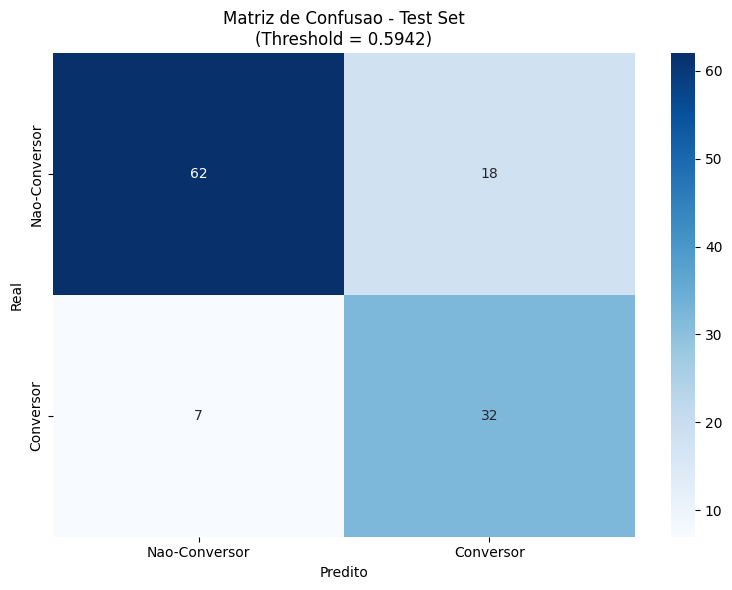

In [35]:
cm = confusion_matrix(y_test, ensemble_test_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nao-Conversor', 'Conversor'],
            yticklabels=['Nao-Conversor', 'Conversor'])
plt.ylabel('Real')
plt.xlabel('Predito')
plt.title(f'Matriz de Confusao - Test Set\n(Threshold = {optimal_threshold:.4f})')
plt.tight_layout()
plt.show()

## Curva ROC

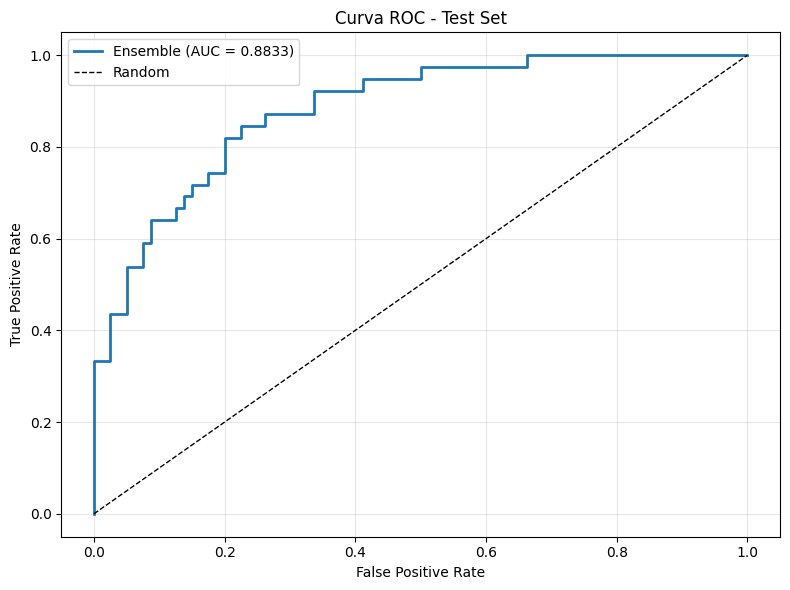

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, ensemble_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Ensemble (AUC = {test_roc_auc_ensemble:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Test Set')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Calibracao de probabilidades

In [37]:
from sklearn.isotonic import IsotonicRegression

calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(ensemble_train, y_train)

ensemble_test_calibrated = calibrator.predict(ensemble_test)

test_roc_auc_calibrated = roc_auc_score(y_test, ensemble_test_calibrated)
print(f"Test ROC-AUC (calibrado): {test_roc_auc_calibrated:.4f}")

Test ROC-AUC (calibrado): 0.8812


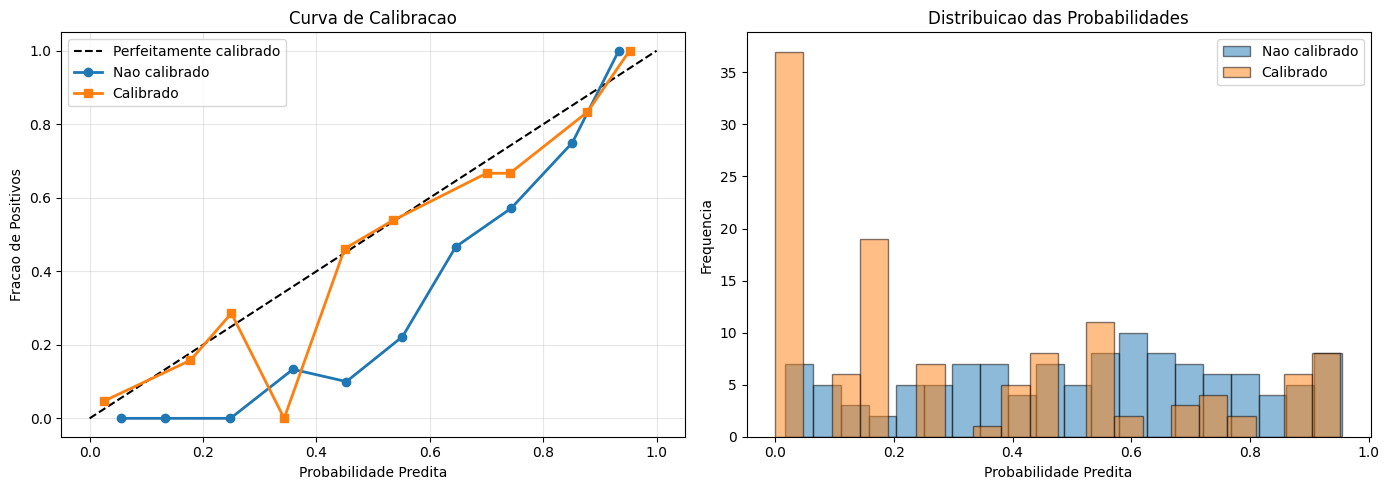

In [38]:
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, ensemble_test, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, ensemble_test_calibrated, n_bins=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfeitamente calibrado')
axes[0].plot(prob_pred_uncal, prob_true_uncal, marker='o', linewidth=2, label='Nao calibrado')
axes[0].plot(prob_pred_cal, prob_true_cal, marker='s', linewidth=2, label='Calibrado')
axes[0].set_xlabel('Probabilidade Predita')
axes[0].set_ylabel('Fracao de Positivos')
axes[0].set_title('Curva de Calibracao')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(ensemble_test, bins=20, alpha=0.5, label='Nao calibrado', edgecolor='black')
axes[1].hist(ensemble_test_calibrated, bins=20, alpha=0.5, label='Calibrado', edgecolor='black')
axes[1].set_xlabel('Probabilidade Predita')
axes[1].set_ylabel('Frequencia')
axes[1].set_title('Distribuicao das Probabilidades')
axes[1].legend()

plt.tight_layout()
plt.show()

## Thresholds para diferentes niveis de sensibilidade

In [39]:
desired_sensitivities = [0.75, 0.80, 0.85, 0.90, 0.95]

sensitivity_results = []

for target_sens in desired_sensitivities:
    best_threshold = 0.5
    best_diff = 1.0
    
    for threshold in np.arange(0, 1.0001, 0.0001):
        y_pred_binary = (ensemble_train >= threshold).astype(int)
        current_sens = recall_score(y_train, y_pred_binary)
        
        if abs(current_sens - target_sens) < best_diff:
            best_diff = abs(current_sens - target_sens)
            best_threshold = threshold
    
    y_test_pred = (ensemble_test >= best_threshold).astype(int)
    
    test_sens = recall_score(y_test, y_test_pred)
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()
    test_spec = tn_test / (tn_test + fp_test)
    
    sensitivity_results.append({
        'target_sensitivity': target_sens,
        'threshold': best_threshold,
        'test_sensitivity': test_sens,
        'test_specificity': test_spec
    })

df_sensitivity_results = pd.DataFrame(sensitivity_results)
df_sensitivity_results

,target_sensitivity,threshold,test_sensitivity,test_specificity
0,0.75,0.6735,0.666667,0.8750
1,0.80,0.6333,0.743590,0.8125
2,0.85,0.5969,0.820513,0.7875
3,0.90,0.5280,0.897436,0.6625
4,0.95,0.4551,0.948718,0.5500


## Comparacao entre modelos individuais e ensemble

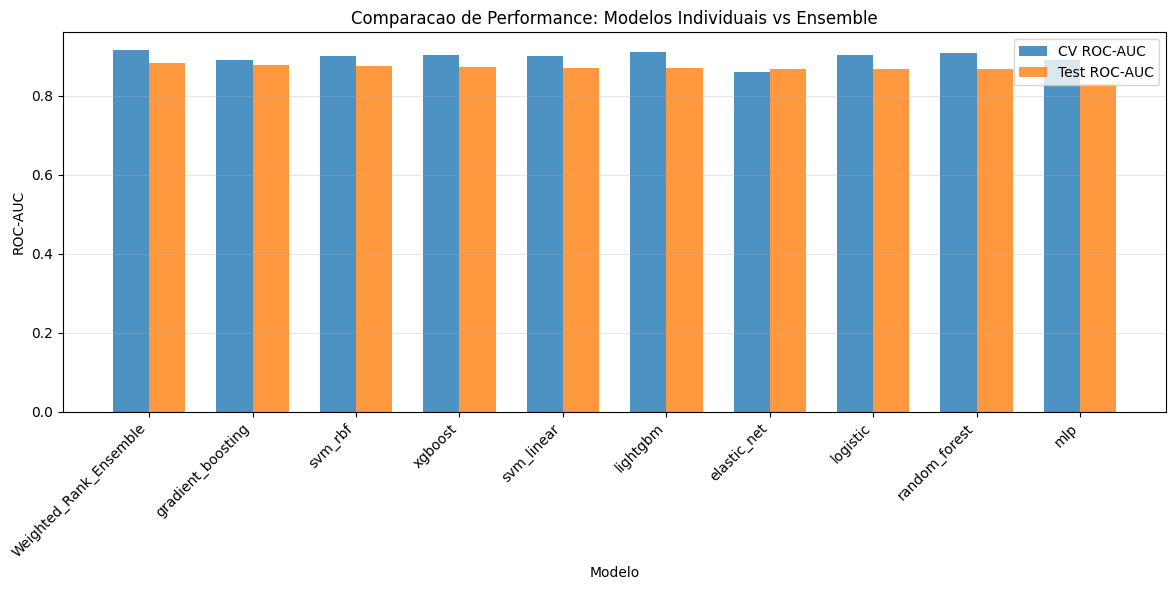

,model,cv_roc_auc,test_roc_auc
9,Weighted_Rank_Ensemble,0.915135,0.883333
6,gradient_boosting,0.891819,0.876923
4,svm_rbf,0.901674,0.875962
2,xgboost,0.903477,0.872756
5,svm_linear,0.899994,0.870833
0,lightgbm,0.910689,0.869551
8,elastic_net,0.859201,0.867949
3,logistic,0.903047,0.867949
1,random_forest,0.907698,0.867308
7,mlp,0.890405,0.831090


In [40]:
comparison_data = df_results_base.copy()
ensemble_row = pd.DataFrame([{
    'model': 'Weighted_Rank_Ensemble',
    'cv_roc_auc': cv_roc_auc_ensemble,
    'test_roc_auc': test_roc_auc_ensemble
}])
comparison_data = pd.concat([comparison_data, ensemble_row], ignore_index=True)
comparison_data = comparison_data.sort_values('test_roc_auc', ascending=False)

plt.figure(figsize=(12, 6))
x = np.arange(len(comparison_data))
width = 0.35

plt.bar(x - width/2, comparison_data['cv_roc_auc'], width, label='CV ROC-AUC', alpha=0.8)
plt.bar(x + width/2, comparison_data['test_roc_auc'], width, label='Test ROC-AUC', alpha=0.8)

plt.xlabel('Modelo')
plt.ylabel('ROC-AUC')
plt.title('Comparacao de Performance: Modelos Individuais vs Ensemble')
plt.xticks(x, comparison_data['model'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

comparison_data

## Salvar resultados

In [41]:
results_dict = {
    'top_models': top_models,
    'weights': weights,
    'optimal_threshold': optimal_threshold,
    'cv_roc_auc': cv_roc_auc_ensemble,
    'test_roc_auc': test_roc_auc_ensemble,
    'test_metrics': {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'f1_score': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'ppv': ppv,
        'npv': npv
    }
}

with open('../models/ensemble_weighted_rank.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

comparison_data.to_csv('../models/ensemble_comparison_results.csv', index=False)
df_sensitivity_results.to_csv('../models/ensemble_sensitivity_thresholds.csv', index=False)

print("Resultados salvos!")

Resultados salvos!


In [42]:
final_summary = f"""
RESUMO FINAL - ENSEMBLE WEIGHTED RANK AVERAGING

Top {top_n} modelos utilizados:
{', '.join(top_models)}

Performance CV (train):
  ROC-AUC: {cv_roc_auc_ensemble:.4f}
  Balanced Accuracy: {train_balanced_acc:.4f}

Performance Test:
  ROC-AUC: {test_roc_auc_ensemble:.4f}
  Balanced Accuracy: {balanced_acc:.4f}
  Sensitivity: {sensitivity:.4f}
  Specificity: {specificity:.4f}
  F1-Score: {f1:.4f}

Threshold otimo: {optimal_threshold:.4f}
"""

print(final_summary)


RESUMO FINAL - ENSEMBLE WEIGHTED RANK AVERAGING

Top 5 modelos utilizados:
lightgbm, random_forest, xgboost, logistic, svm_rbf

Performance CV (train):
  ROC-AUC: 0.9151
  Balanced Accuracy: 0.8436

Performance Test:
  ROC-AUC: 0.8833
  Balanced Accuracy: 0.7978
  Sensitivity: 0.8205
  Specificity: 0.7750
  F1-Score: 0.7191

Threshold otimo: 0.5942

